In [8]:
import pandas as pd

In [25]:
DATA_DIR = "../../data"

def add_data_dir(filename):
    return f"{DATA_DIR}/{filename}"

In [26]:
def load_raw_data():
    data = pd.read_csv(add_data_dir("aita_clean.csv"))
    return data

In [27]:
raw_data = load_raw_data()
print(raw_data.head())

       id     timestamp                                              title  \
0  1ytxov  1.393279e+09  [AITA] I wrote an explanation in TIL and came ...   
1  1yu29c  1.393281e+09               [AITA] Threw my parent's donuts away   
2  1yu8hi  1.393285e+09        I told a goth girl she looked like a clown.   
3  1yuc78  1.393287e+09  [AItA]: Argument I had with another redditor i...   
4  1yueqb  1.393288e+09  [AITA] I let my story get a little long and bo...   

                                                body        edited  \
0  [Here is the post in question](http://www.redd...         False   
1  My parents are diabetic, morbidly obese, and a...  1393290576.0   
2                                        I was four.         False   
3  http://www.reddit.com/r/HIMYM/comments/1vvfkq/...  1393286962.0   
4                                                NaN         False   

           verdict  score  num_comments  is_asshole  
0          asshole     52          13.0           1  
1 

In [28]:
print("len data before removing nulls", len(raw_data))
raw_data = raw_data.dropna(subset=["body","verdict"])
print("len data after removing nulls", len(raw_data))
raw_data = raw_data.drop_duplicates()
print("len data after removing duplicates", len(raw_data))


len data before removing nulls 97628
len data after removing nulls 97541
len data after removing duplicates 97541


In [33]:
import spacy
import re
import pandas as pd
from tqdm import tqdm

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_author_age_gender(text):
    text = text[:250].strip()
    # Enhanced regex patterns for common self-identification patterns
    author_patterns = [
        r'\bI\s?\((\d{1,2})([MFmf])\)',
        r'\bI am a (\d{1,2})\s*(male|female)\b',
        r'\bI am (\d{1,2})\s*(years\s*old|yo)\b',
        r'\bI\'m (\d{1,2})\s*(years\s*old|yo)\b',
        r'\bI\'m a (\d{1,2})\s*(male|female)\b',
        r'\b(\d{1,2})\s*(M|F)\b'
    ]
    
    for pattern in author_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            age = match.group(1).strip()
            gender = match.group(2).strip().upper()
            if gender == 'M' or gender == 'MALE':
                gender = 'Male'
            elif gender == 'F' or gender == 'FEMALE':
                gender = 'Female'
            return age, gender
    
    # Use spaCy for more context-aware extraction
    doc = nlp(text)
    for sent in doc.sents:
        age = None
        gender = None
        for token in sent:
            try:
                if token.like_num and 10 <= int(token.text) <= 99:  # Age range between 10 and 99
                    age = token.text
            except ValueError:
                continue
            if token.text.lower() in ['male', 'female', 'm', 'f']:
                gender = 'Male' if token.text.lower() in ['male', 'm'] else 'Female'
        if age and gender:
            return age, gender
    
    return None, None


# Convert body column to string type
raw_data['body'] = raw_data['body'].astype(str)

# Process data in batches
batch_size = 1000
results = []
author_age_gender = []
for _, row in tqdm(raw_data.iterrows(), total=raw_data.shape[0]):
    author_age_gender.append(extract_author_age_gender(row['body']))

# Add the results to the DataFrame
raw_data['author_age_gender'] = author_age_gender



100%|██████████| 97541/97541 [53:00<00:00, 30.67it/s]  


In [36]:
raw_data["author_age_gender"] = raw_data["author_age_gender"].astype(str)
print(len(raw_data))
not_nulls = raw_data[raw_data['author_age_gender']!="(None, None)"]
print(len(not_nulls))
raw_data.to_csv(add_data_dir("aita_clean.csv"), index=False)

not_nulls.to_csv(add_data_dir("aita_clean_with_age_or_gender.csv"), index=False)

# Print the results
print(not_nulls)


97541
10936
           id     timestamp  \
41     227kaj  1.396635e+09   
97     2g0lkt  1.410366e+09   
107    2lcln7  1.415174e+09   
248    38y689  1.433711e+09   
330    3ck8gf  1.436370e+09   
...       ...           ...   
97618  ex8r6i  1.580575e+09   
97619  ex8su3  1.580576e+09   
97623  ex94w5  1.580577e+09   
97624  ex970f  1.580577e+09   
97627  ex9g78  1.580578e+09   

                                                   title  \
41       Stuck in the middle of my parents messy divorce   
97     AITA for not turning and cutting off oncoming ...   
107    AMA for my comment i made towards my moms boyf...   
248    AITA for not wanting a relationship with my fa...   
330                      AITA for not paying back my ex?   
...                                                  ...   
97618  AITA if I stopped offering my friend a ride ho...   
97619          AITA for knocking on my neighbours' wall?   
97623  AITA for telling my sister she is being a spoi...   
97624  AITA for

In [39]:
not_nulls.loc[:, "gender"] = not_nulls["author_age_gender"].apply(lambda x: x.split(",")[1].replace(" ", "").replace(")", "").replace("'", "").lower())
not_nulls = not_nulls[not_nulls["gender"].isin(["male","female"])]
not_nulls.loc[:, "age"] = not_nulls["author_age_gender"].apply(lambda x: x.split(",")[0].replace(" ", "").replace("(", "").replace("'", "").lower()).astype(int)
not_nulls = not_nulls[(not_nulls["age"]>10) & (not_nulls["age"]<80)]

In [41]:
del not_nulls["author_age_gender"]
not_nulls.to_csv(add_data_dir("aita_clean_with_age_and_gender.csv"), index=False)

In [45]:
# weve stopped manual labelling in row 124
df = pd.read_csv(add_data_dir("aita_clean_with_age_and_gender_fixed.csv"))
df["timestamp"] = pd.to_datetime(df["timestamp"])

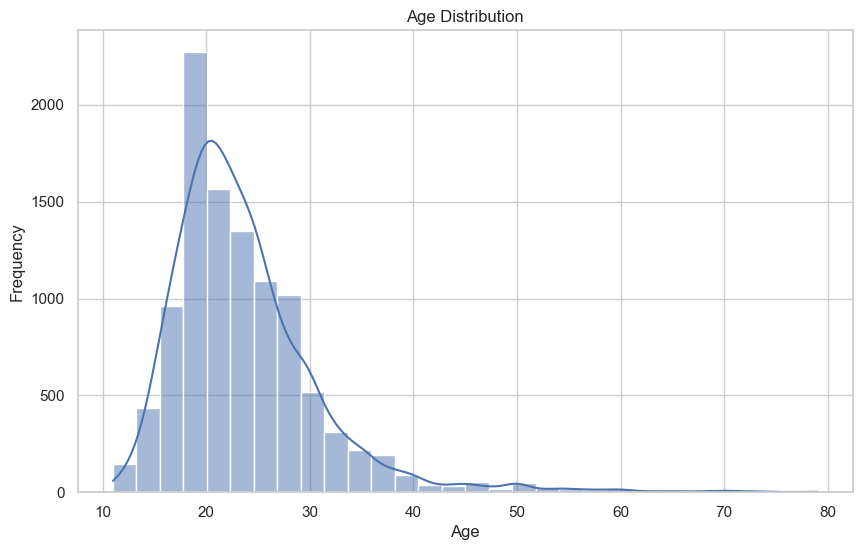

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_46405/106068064.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette='Set2')


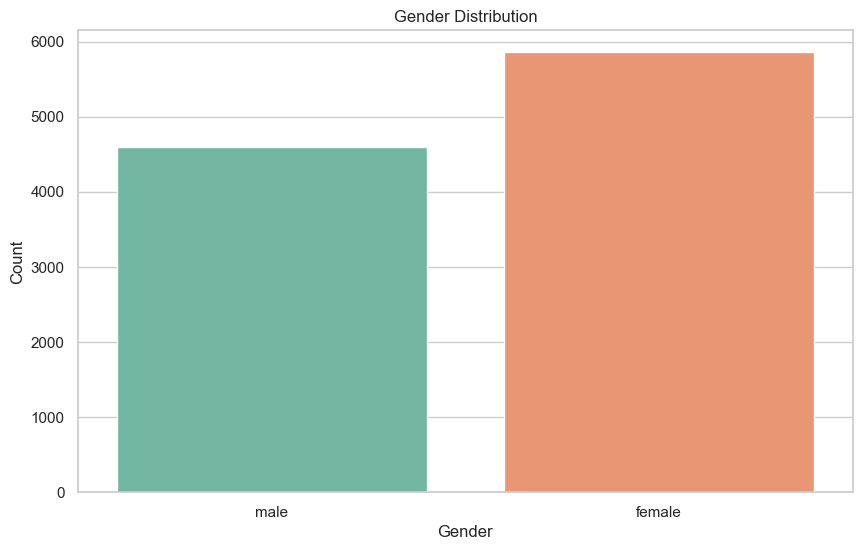

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_46405/106068064.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='age', data=df, palette='Set2')


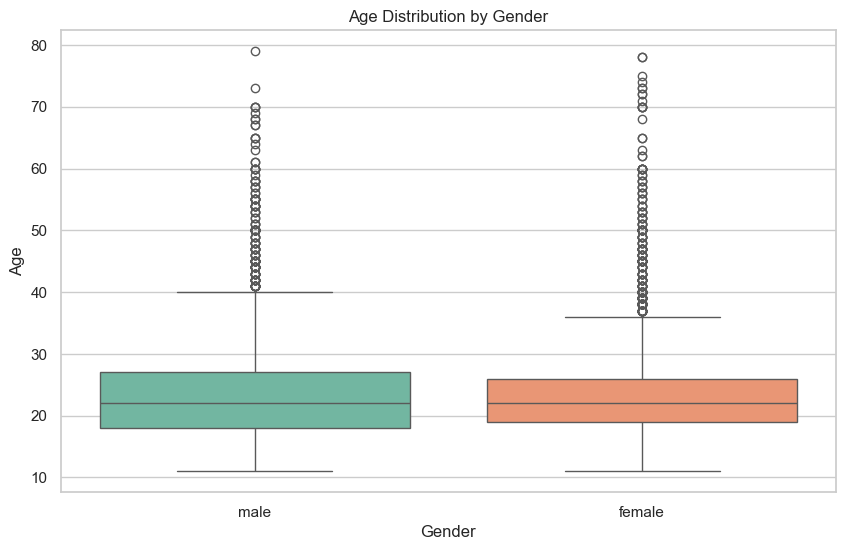

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram of Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Bar Plot of Gender Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=df, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Box Plot of Age Distribution by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='age', data=df, palette='Set2')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()


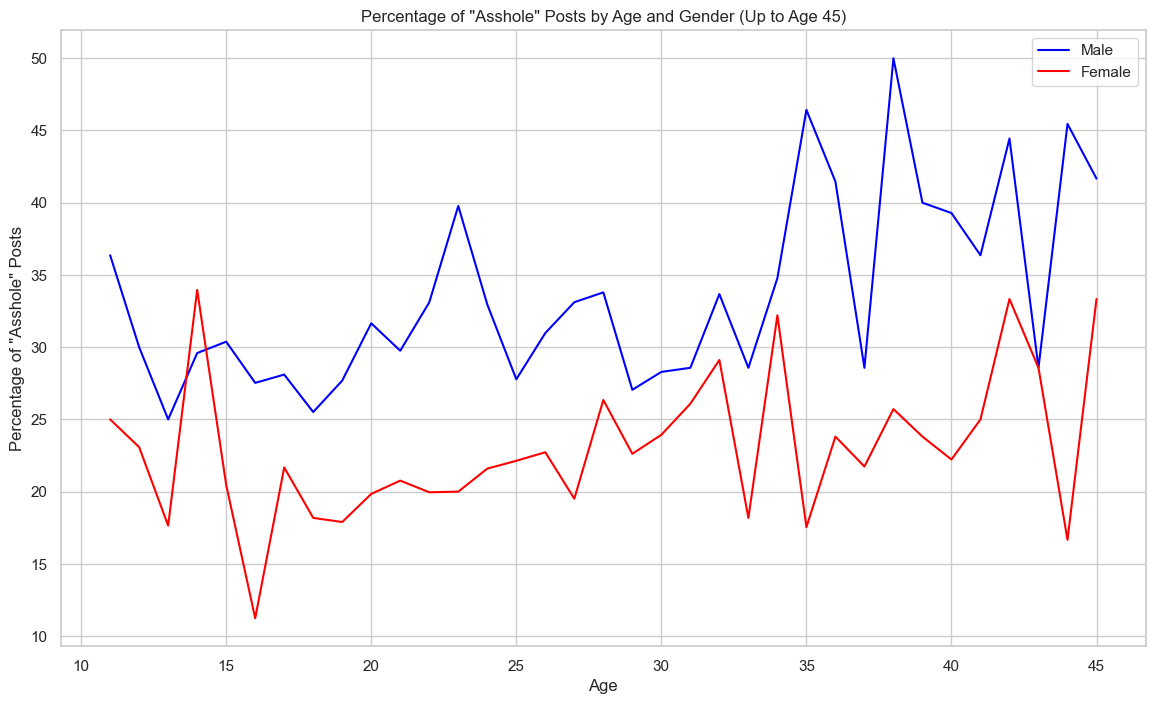

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_46405/614322251.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette='Set2')


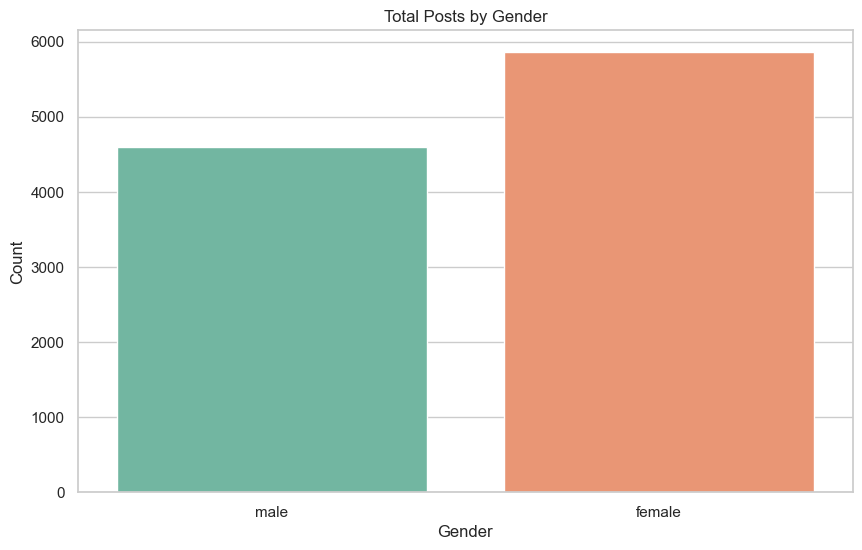

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_46405/614322251.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y='age', data=df, palette='Set2')


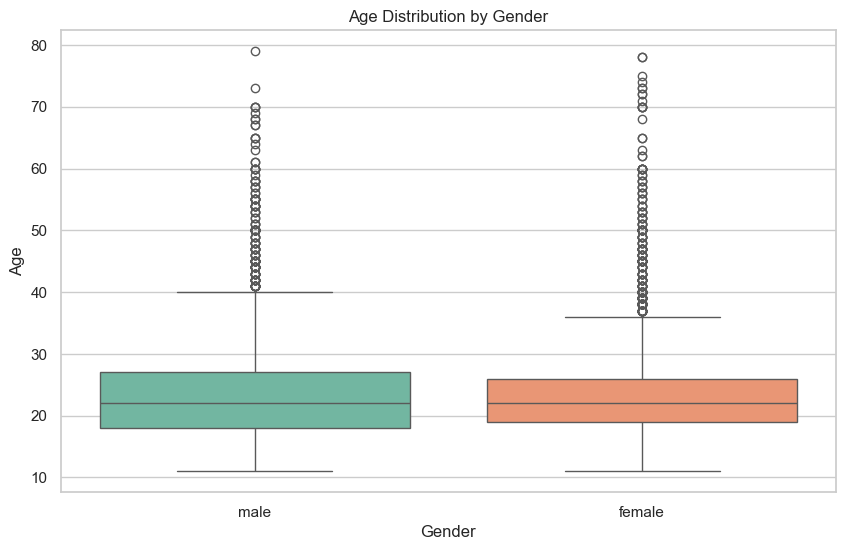

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_46405/614322251.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.groupby('gender').resample('M').size().unstack(level=0)


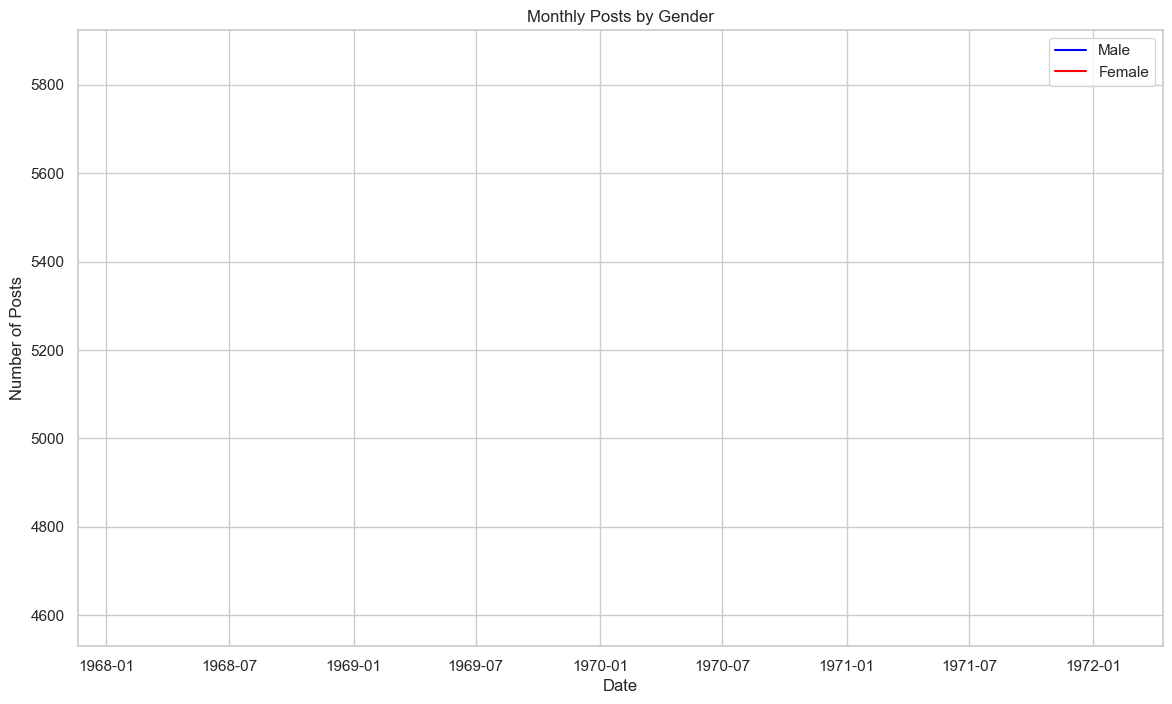

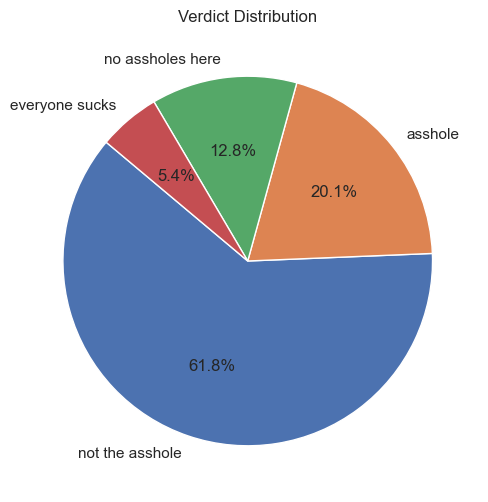

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the timestamp as the index if not already done
df.set_index('timestamp', inplace=True)

# Filter the data to include only ages up to 45
data_under_45 = df[df['age'] <= 45]
asshole_data_under_45 = data_under_45[data_under_45['is_asshole'] == 1]

# Group by age and gender, then calculate the percentage of 'asshole' posts
asshole_counts_under_45 = asshole_data_under_45.groupby(['age', 'gender']).size().unstack(fill_value=0)
total_counts_under_45 = data_under_45.groupby(['age', 'gender']).size().unstack(fill_value=0)
percentage_asshole_under_45 = (asshole_counts_under_45 / total_counts_under_45) * 100

# Line Plot of "Asshole" Posts by Age and Gender (up to age 45)
plt.figure(figsize=(14, 8))
plt.plot(percentage_asshole_under_45.index, percentage_asshole_under_45['male'], label='Male', color='blue')
plt.plot(percentage_asshole_under_45.index, percentage_asshole_under_45['female'], label='Female', color='red')
plt.title('Percentage of "Asshole" Posts by Age and Gender (Up to Age 45)')
plt.xlabel('Age')
plt.ylabel('Percentage of "Asshole" Posts')
plt.legend()
plt.show()

# Bar Plot of Total Posts by Gender
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=df, palette='Set2')
plt.title('Total Posts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Box Plot of Age Distribution by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='age', data=df, palette='Set2')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

# Time Series of Monthly Posts by Gender
monthly_counts = df.groupby('gender').resample('M').size().unstack(level=0)
plt.figure(figsize=(14, 8))
plt.plot(monthly_counts.index, monthly_counts['male'], label='Male', color='blue')
plt.plot(monthly_counts.index, monthly_counts['female'], label='Female', color='red')
plt.title('Monthly Posts by Gender')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()

# Pie Chart of Verdict Distribution
verdict_counts = df['verdict'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(verdict_counts, labels=verdict_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Verdict Distribution')
plt.show()


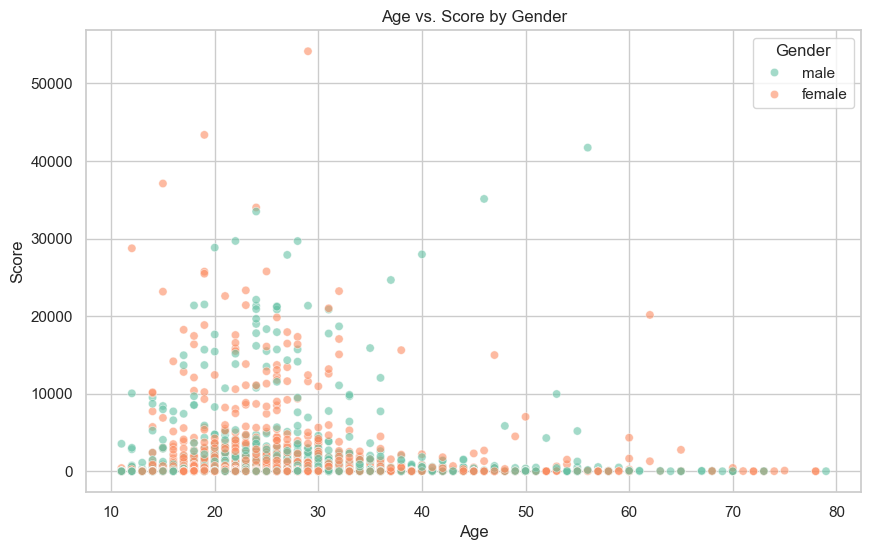

/var/folders/c4/wctb__gj70v0_v8tlv9zqdnr0000gn/T/ipykernel_46405/3559779589.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='gender', y='age', data=df, palette='Set2')


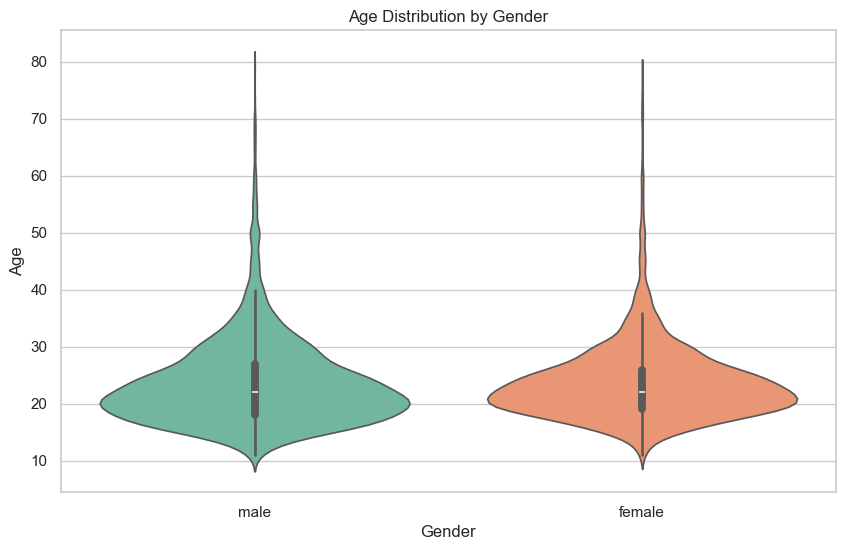

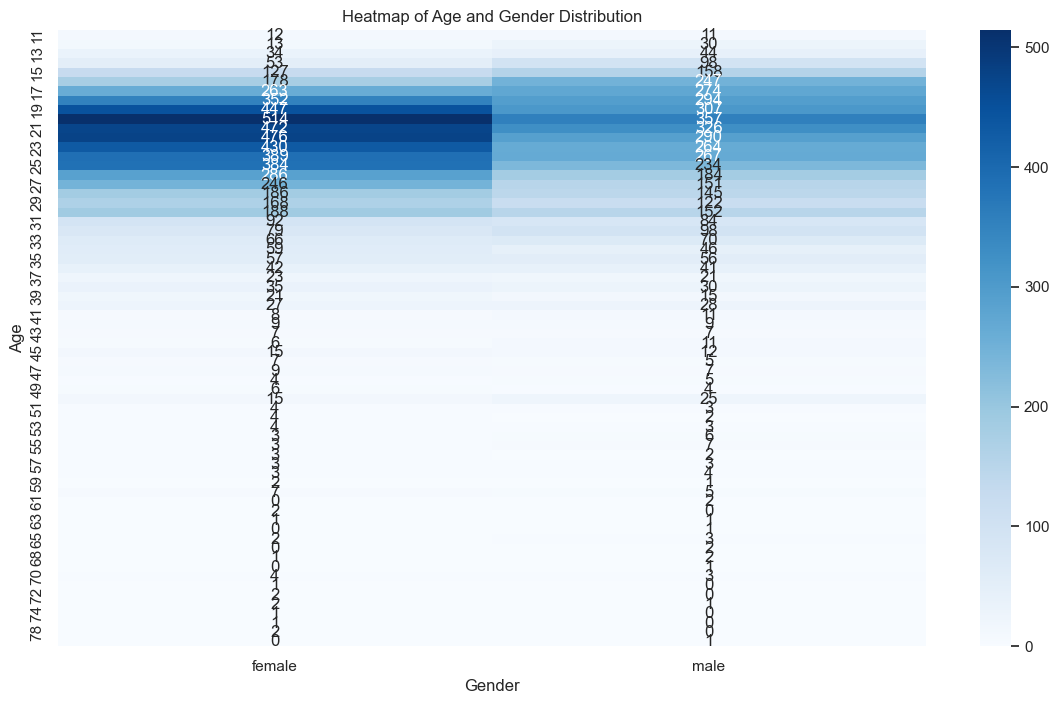

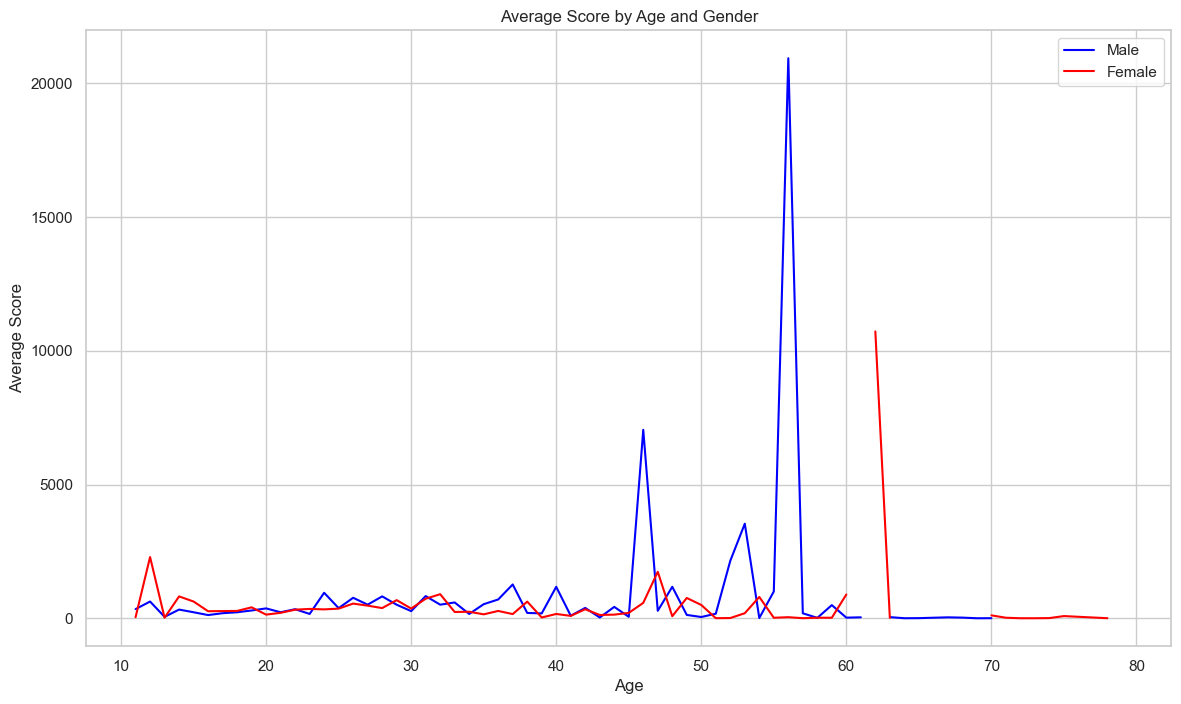

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot of Age vs. Score by Gender
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='score', hue='gender', data=df, palette='Set2', alpha=0.6)
plt.title('Age vs. Score by Gender')
plt.xlabel('Age')
plt.ylabel('Score')
plt.legend(title='Gender')
plt.show()

# Violin Plot of Age Distribution by Gender
plt.figure(figsize=(10, 6))
sns.violinplot(x='gender', y='age', data=df, palette='Set2')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

# Heatmap of Age and Gender Distribution
age_gender_counts = df.groupby(['age', 'gender']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(age_gender_counts, cmap='Blues', annot=True, fmt='d')
plt.title('Heatmap of Age and Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

# Line Plot of Average Score by Age and Gender
average_score_by_age_gender = df.groupby(['age', 'gender'])['score'].mean().unstack()
plt.figure(figsize=(14, 8))
plt.plot(average_score_by_age_gender.index, average_score_by_age_gender['male'], label='Male', color='blue')
plt.plot(average_score_by_age_gender.index, average_score_by_age_gender['female'], label='Female', color='red')
plt.title('Average Score by Age and Gender')
plt.xlabel('Age')
plt.ylabel('Average Score')
plt.legend()
plt.show()


In [14]:
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_age_gender(body):
    # Regular expression to find age and gender in the format (number(m/f))
    pattern = r"\b(\d+)([mf])\b"
    matches = re.findall(pattern, body)
    return matches

def extract_topic(txt):
    # Use spaCy to extract the main topic from the title
    doc = nlp(txt)
    topic_labels = {
        "ORG", "PERSON", "GPE", "NORP", "PRODUCT", "EVENT", "FAC", "LAW", "LANGUAGE", 
        "WORK_OF_ART", "LOC", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"
    }
    for ent in doc.ents:
        if ent.label_ in topic_labels:
            print(ent.text, ent.label_)
            return ent.text
    return None  # Fallback to the full title if no entities are found

results = []

for entry in raw_data.to_dict(orient='records')[:20]:
    body = entry['body']
    title = entry['title']
    author_info = extract_age_gender(body)
    topic = extract_topic(f"{title} {body}")
    
    author_age_gender = None
    subject_age_gender = None

    if author_info:
        # Assuming the first match is the author's info and the second (if exists) is the subject's info
        if len(author_info) > 0:
            author_age_gender = author_info[0]
        if len(author_info) > 1:
            subject_age_gender = author_info[1]
    
    result = {
        'author_age': author_age_gender[0] if author_age_gender else None,
        'author_gender': author_age_gender[1] if author_age_gender else None,
        'subject_age': subject_age_gender[0] if subject_age_gender else None,
        'subject_gender': subject_age_gender[1] if subject_age_gender else None,
        'topic': topic
    }
    results.append(result)

for result in results:
    print(result)


AITA ORG
AITA ORG
four CARDINAL


TypeError: expected string or bytes-like object